c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   0   10   22   63   77  100  115  135  174  195  200  227  234  241
  266  278  310  319  327  333  356  371  391  430  451  456  483  490
  497  522  534  575  583  589  612  627  647  656  686  707  712  739
  746  753  778  790  845  868  883  903  942  952  963 1002 1009 1034
 1046 1087 1095 1101 1124 1139 1159 1198 1208 1219 1224 1251 1258 1265] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Completed LogisticRegression with SelectKBest_ANOVA
Completed RandomForest with SelectKBest_ANOVA
Completed GradientBoosting with SelectKBest_ANOVA
Completed SVC with SelectKBest_ANOVA
Completed KNeighbors with SelectKBest_ANOVA
Completed DecisionTree with SelectKBest_ANOVA
Completed LogisticRegression with VarianceThreshold
Completed RandomForest with VarianceThreshold
Completed GradientBoosting with VarianceThreshold
Completed SVC with VarianceThreshold
Completed KNeighbors with VarianceThreshold
Completed DecisionTree with VarianceThreshold
Completed LogisticRegression with SelectFromModel_RF
Completed RandomForest with SelectFromModel_RF
Completed GradientBoosting with SelectFromModel_RF
Completed SVC with SelectFromModel_RF
Completed KNeighbors with SelectFromModel_RF
Completed DecisionTree with SelectFromModel_RF

All results have been saved to e:\model_comparison_results_deep_with AUC and ROC.xlsx


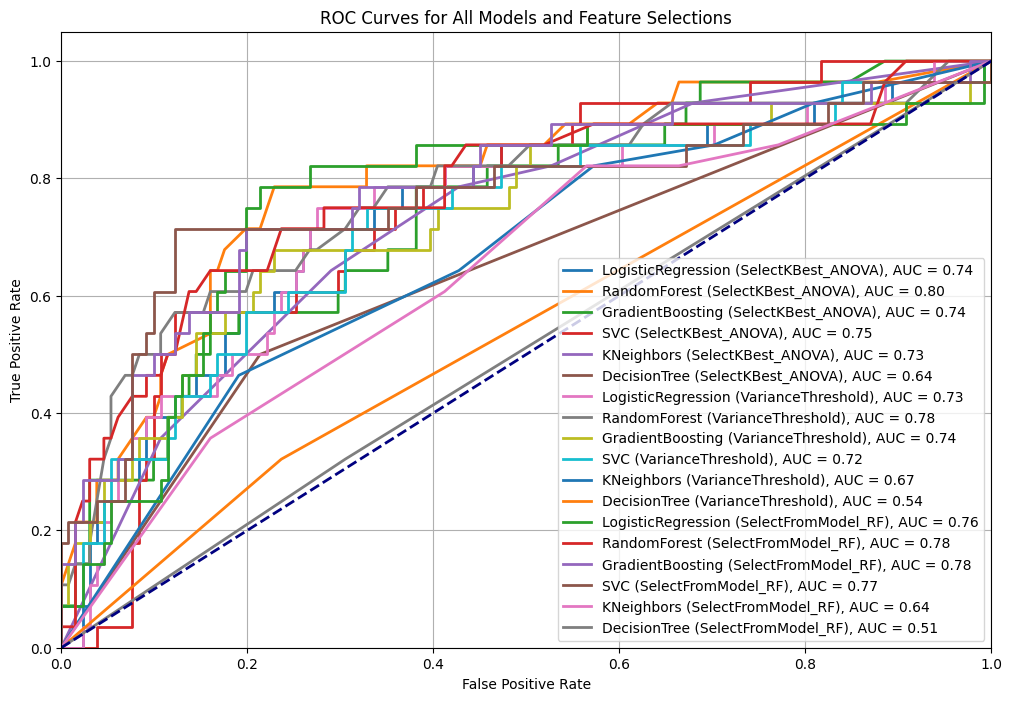

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import openpyxl

# Load the dataset
file_path = r'c:\Users\alire\Downloads\labelstep3 (1).xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Ensure target variable is encoded properly
if df['Cancer Status'].dtype == 'object':
    le = LabelEncoder()
    df['Cancer Status'] = le.fit_transform(df['Cancer Status'])

# Remove non-numeric columns and separate features and target
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=['Cancer Status'], errors='ignore')
y = df['Cancer Status']

# Handle missing values (if any)
X = X.fillna(X.mean())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# List of feature selection methods
feature_selectors = {
    'SelectKBest_ANOVA': SelectKBest(score_func=f_classif, k=20),
    'VarianceThreshold': VarianceThreshold(threshold=0.0),  # Adjusted threshold to 0.0
    'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
}

# List of machine learning models (make sure that each has predict_proba available)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to store results and ROC curve data
results = []
roc_data = {}

# Iterate over feature selectors
for fs_name, fs in feature_selectors.items():
    # Fit the feature selector on training data
    fs.fit(X_train_resampled, y_train_resampled)
    X_train_fs = fs.transform(X_train_resampled)
    X_test_fs = fs.transform(X_test)
    
    # Iterate over models
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fs, y_train_resampled)
        # Predict on test data
        y_pred = model.predict(X_test_fs)
        
        # Calculate metrics: Precision, Recall, F1-Score
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        # Compute predicted probabilities and ROC AUC (for binary classification)
        y_prob = model.predict_proba(X_test_fs)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        
        # Compute ROC curve data points
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # Store results
        results.append({
            'Feature_Selection': fs_name,
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'ROC_AUC': auc
        })
        
        # Save ROC data for plotting; key is a tuple (feature_selector, model)
        roc_data[(fs_name, model_name)] = (fpr, tpr, auc)
        
        print(f"Completed {model_name} with {fs_name}")

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame(results)
output_file = r'e:\model_comparison_results_deep_with AUC and ROC.xlsx'  # Change the output file path if needed
results_df.to_excel(output_file, index=False)
print(f"\nAll results have been saved to {output_file}")

# Plot ROC curves for all models and feature selections
plt.figure(figsize=(12, 8))
for (fs_name, model_name), (fpr, tpr, auc) in roc_data.items():
    label = f"{model_name} ({fs_name}), AUC = {auc:.2f}"
    plt.plot(fpr, tpr, lw=2, label=label)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models and Feature Selections')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   0   10   22   63   77  100  115  135  174  195  200  227  234  241
  266  278  310  319  327  333  356  371  391  430  451  456  483  490
  497  522  534  575  583  589  612  627  647  656  686  707  712  739
  746  753  778  790  845  868  883  903  942  952  963 1002 1009 1034
 1046 1087 1095 1101 1124 1139 1159 1198 1208 1219 1224 1251 1258 1265] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Completed LogisticRegression with SelectKBest_ANOVA
Completed RandomForest with SelectKBest_ANOVA
Completed GradientBoosting with SelectKBest_ANOVA
Completed SVC with SelectKBest_ANOVA
Completed KNeighbors with SelectKBest_ANOVA
Completed DecisionTree with SelectKBest_ANOVA
Completed LogisticRegression with VarianceThreshold
Completed RandomForest with VarianceThreshold
Completed GradientBoosting with VarianceThreshold
Completed SVC with VarianceThreshold
Completed KNeighbors with VarianceThreshold
Completed DecisionTree with VarianceThreshold
Completed LogisticRegression with SelectFromModel_RF
Completed RandomForest with SelectFromModel_RF
Completed GradientBoosting with SelectFromModel_RF
Completed SVC with SelectFromModel_RF
Completed KNeighbors with SelectFromModel_RF
Completed DecisionTree with SelectFromModel_RF

All results have been saved to e:\model_comparison_results_deep.xlsx


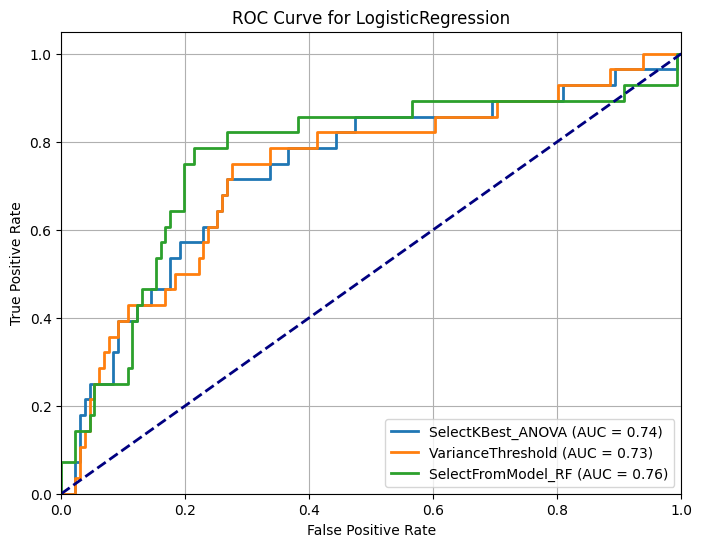

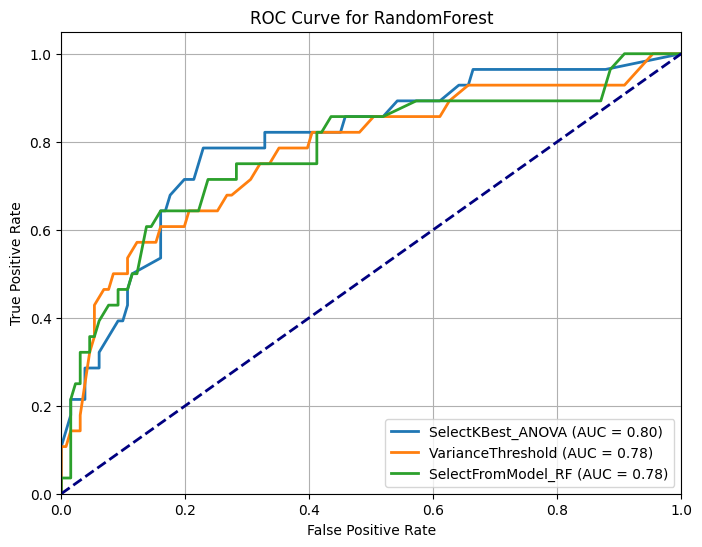

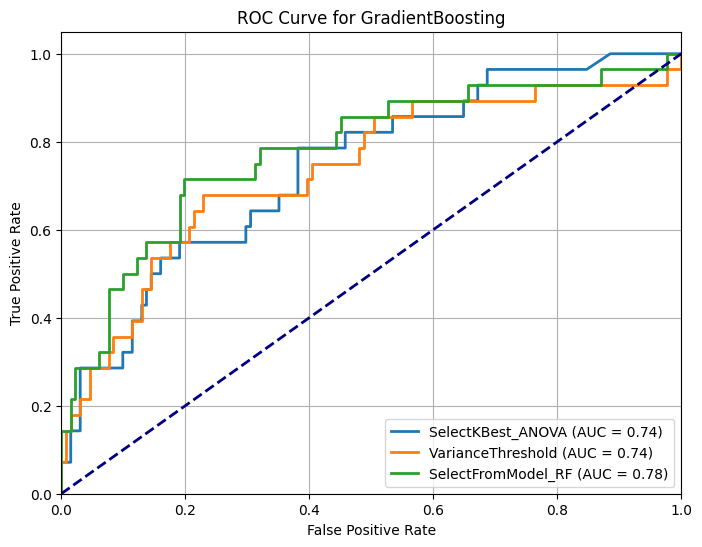

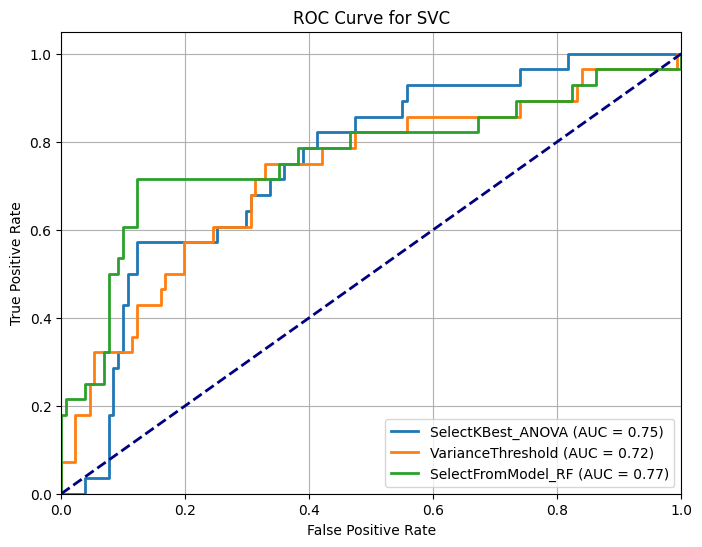

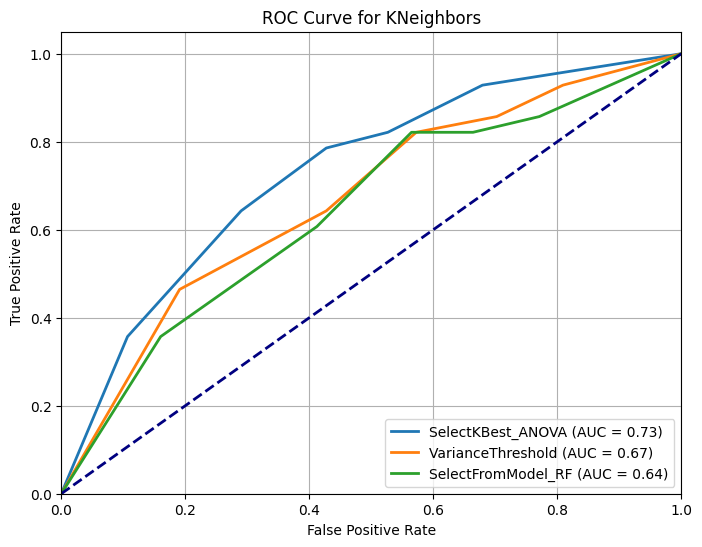

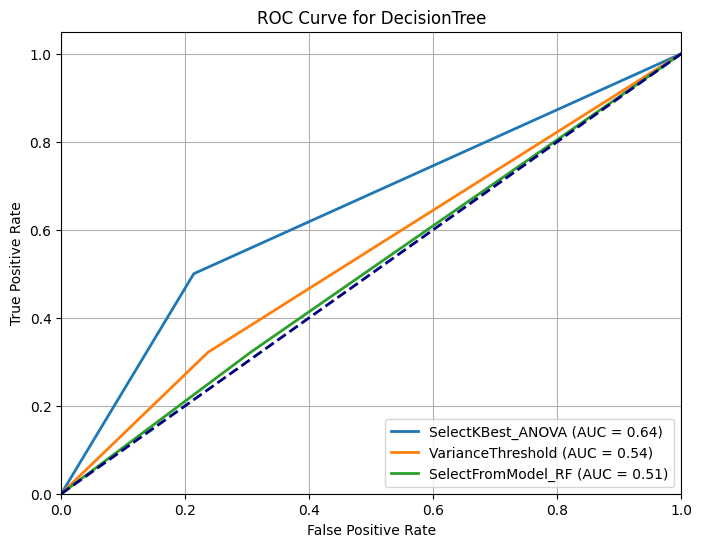

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import openpyxl

# Load the dataset
file_path = r'c:\Users\alire\Downloads\labelstep3 (1).xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Ensure target variable is encoded properly
if df['Cancer Status'].dtype == 'object':
    le = LabelEncoder()
    df['Cancer Status'] = le.fit_transform(df['Cancer Status'])

# Remove non-numeric columns and separate features and target
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=['Cancer Status'], errors='ignore')
y = df['Cancer Status']

# Handle missing values (if any)
X = X.fillna(X.mean())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# List of feature selection methods
feature_selectors = {
    'SelectKBest_ANOVA': SelectKBest(score_func=f_classif, k=20),
    'VarianceThreshold': VarianceThreshold(threshold=0.0),  # Adjusted threshold to 0.0
    'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
}

# List of machine learning models (all models should support predict_proba)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to store results and ROC curve data
results = []
roc_data = {}  # Will store keys as (model_name, fs_name) with (fpr, tpr, auc)

# Iterate over feature selectors and models
for fs_name, fs in feature_selectors.items():
    # Fit the feature selector on training data
    fs.fit(X_train_resampled, y_train_resampled)
    X_train_fs = fs.transform(X_train_resampled)
    X_test_fs = fs.transform(X_test)
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fs, y_train_resampled)
        # Predict on test data
        y_pred = model.predict(X_test_fs)
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        # Get predicted probabilities for the positive class and compute ROC AUC
        y_prob = model.predict_proba(X_test_fs)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        
        # Compute ROC curve data
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # Save the metrics and ROC data
        results.append({
            'Feature_Selection': fs_name,
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'ROC_AUC': auc
        })
        roc_data[(model_name, fs_name)] = (fpr, tpr, auc)
        
        print(f"Completed {model_name} with {fs_name}")

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame(results)
output_file = r'e:\model_comparison_results_deep.xlsx'  # Change the output file path if needed
results_df.to_excel(output_file, index=False)
print(f"\nAll results have been saved to {output_file}")

# Plot ROC curves separately for each model (comparing different feature selection methods)
models_list = list(models.keys())
for model_name in models_list:
    plt.figure(figsize=(8, 6))
    for fs_name in feature_selectors.keys():
        key = (model_name, fs_name)
        if key in roc_data:
            fpr, tpr, auc = roc_data[key]
            label = f"{fs_name} (AUC = {auc:.2f})"
            plt.plot(fpr, tpr, lw=2, label=label)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

Completed LogisticRegression with SelectKBest_ANOVA
Completed RandomForest with SelectKBest_ANOVA
Completed GradientBoosting with SelectKBest_ANOVA
Completed SVC with SelectKBest_ANOVA
Completed KNeighbors with SelectKBest_ANOVA
Completed DecisionTree with SelectKBest_ANOVA
Completed LogisticRegression with VarianceThreshold
Completed RandomForest with VarianceThreshold
Completed GradientBoosting with VarianceThreshold
Completed SVC with VarianceThreshold
Completed KNeighbors with VarianceThreshold
Completed DecisionTree with VarianceThreshold
Completed LogisticRegression with SelectFromModel_RF
Completed RandomForest with SelectFromModel_RF
Completed GradientBoosting with SelectFromModel_RF
Completed SVC with SelectFromModel_RF
Completed KNeighbors with SelectFromModel_RF
Completed DecisionTree with SelectFromModel_RF

All results have been saved to e:\model_comparison_results_radiomics.xlsx


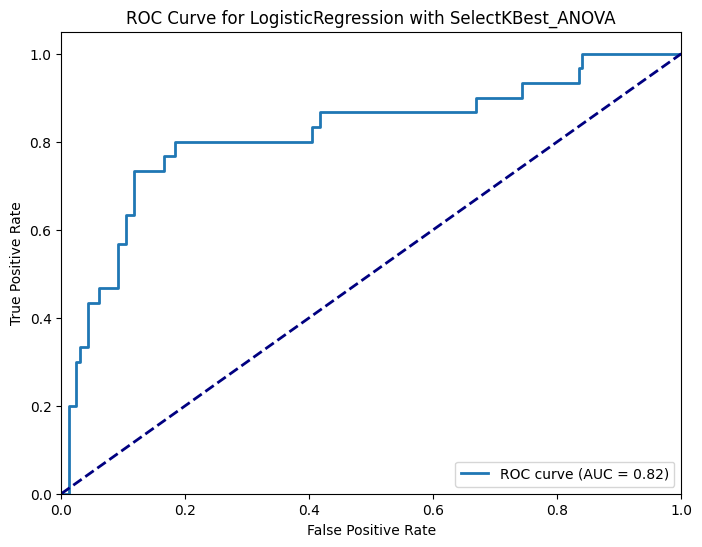

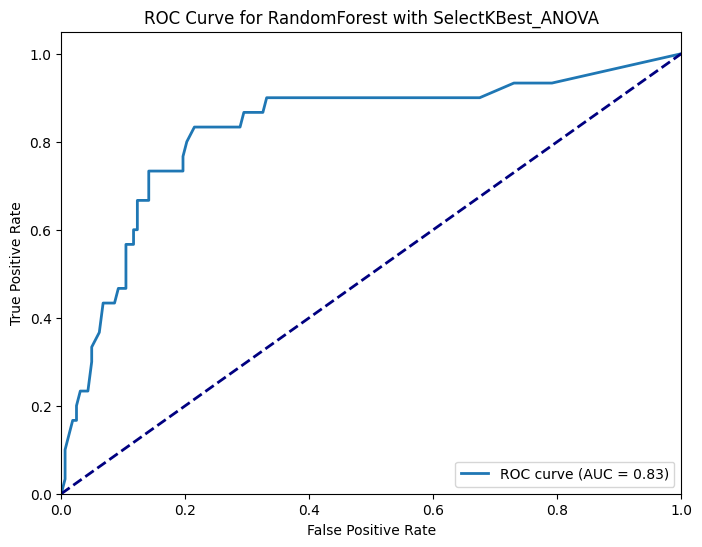

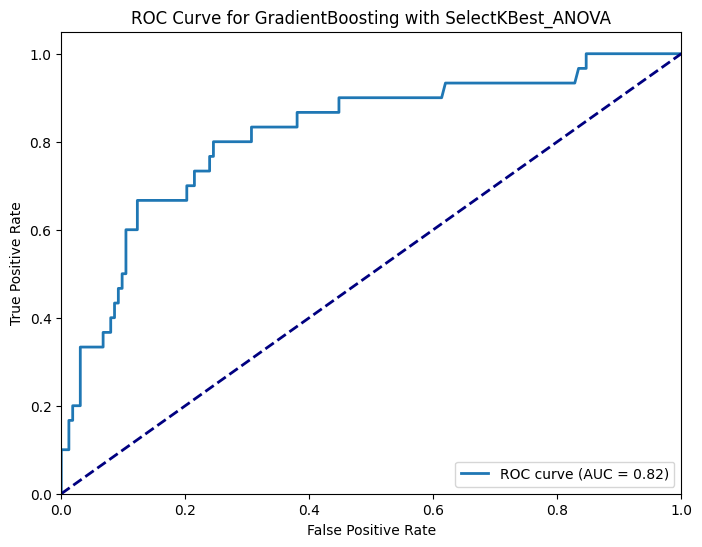

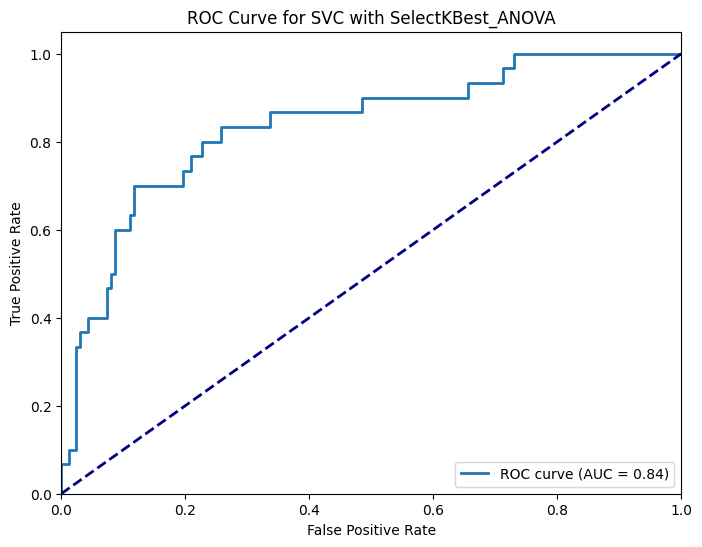

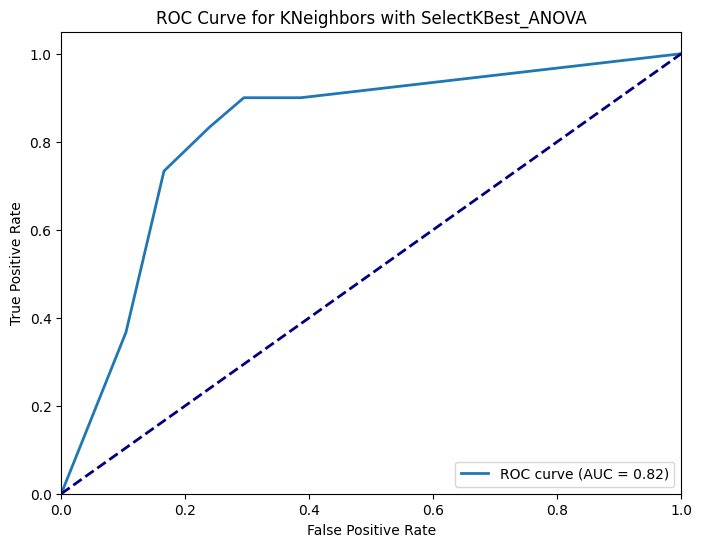

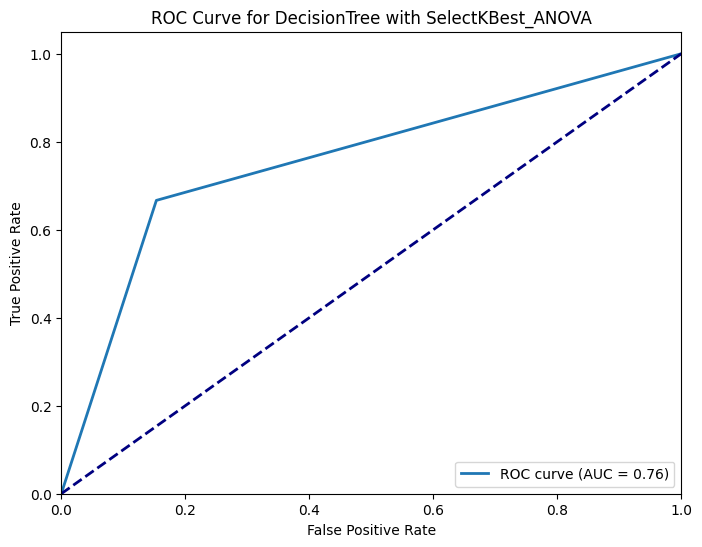

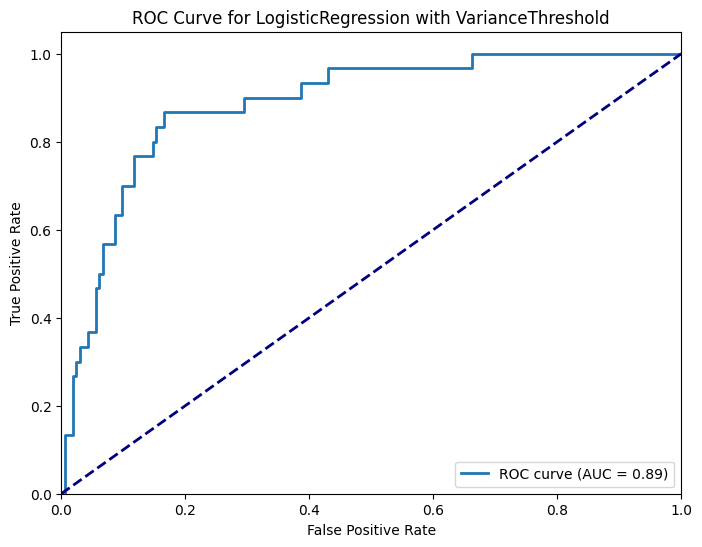

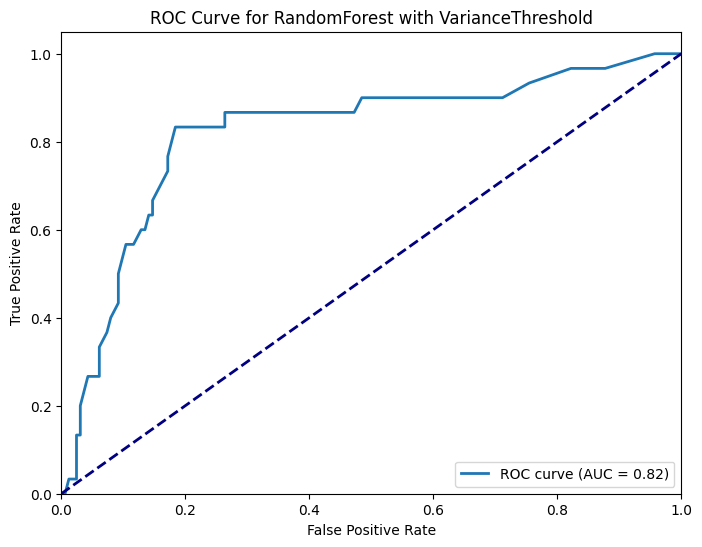

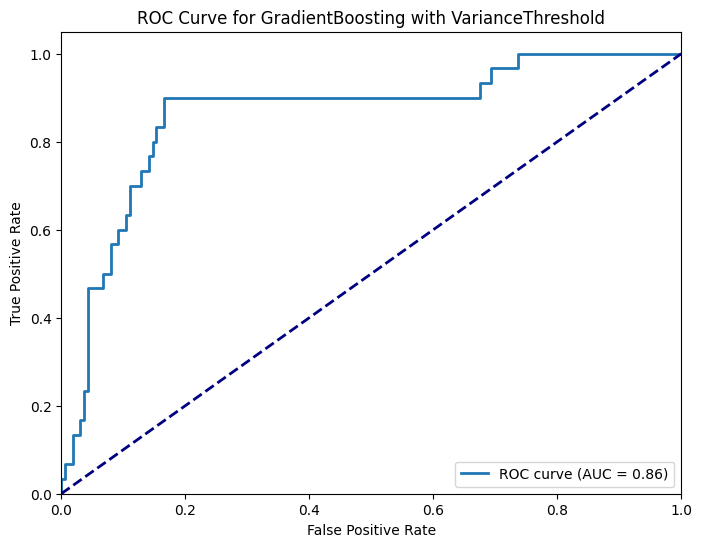

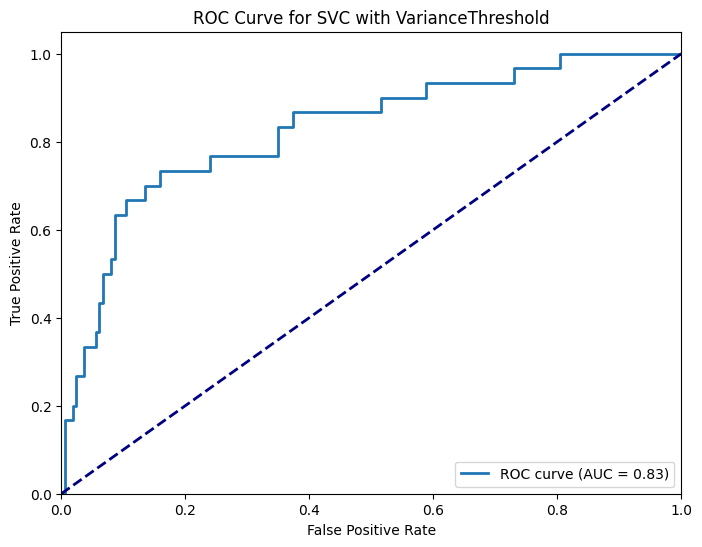

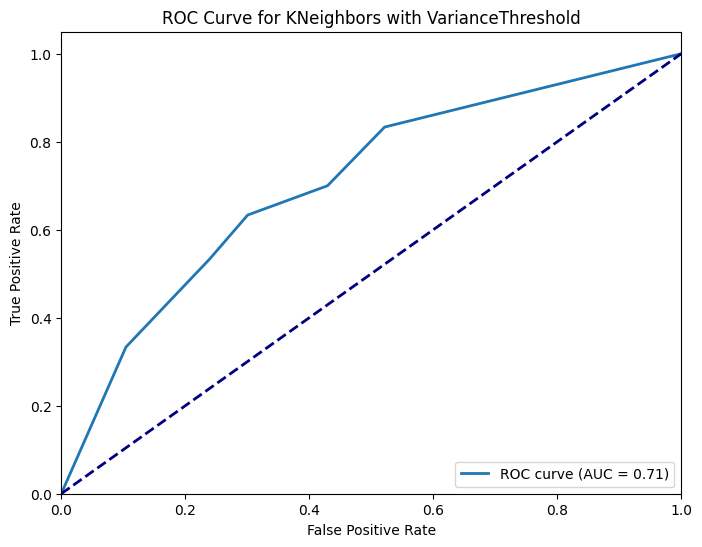

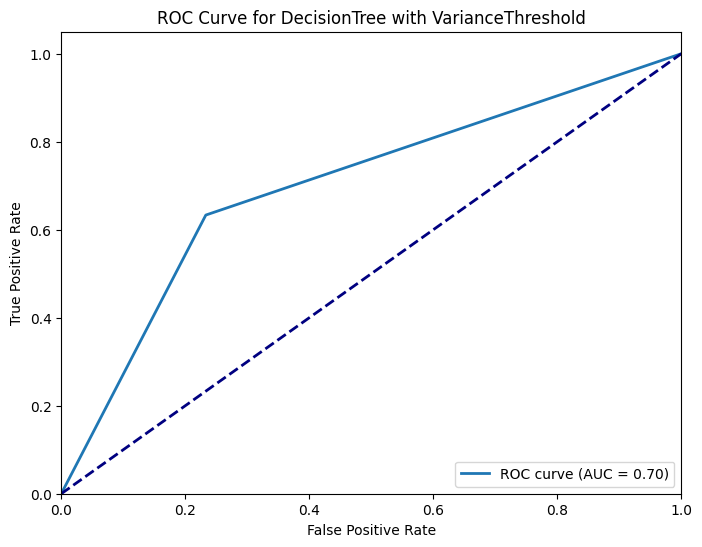

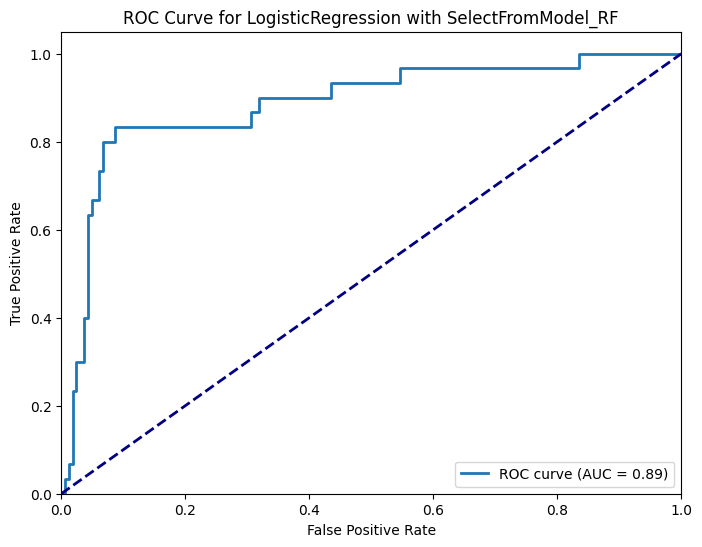

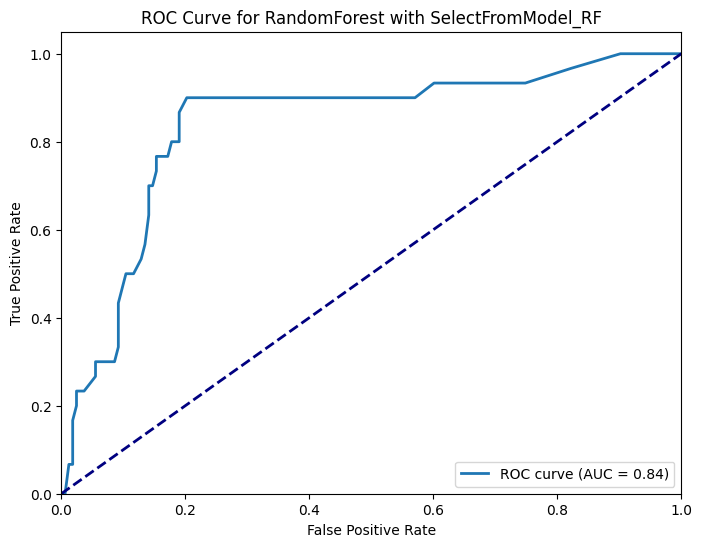

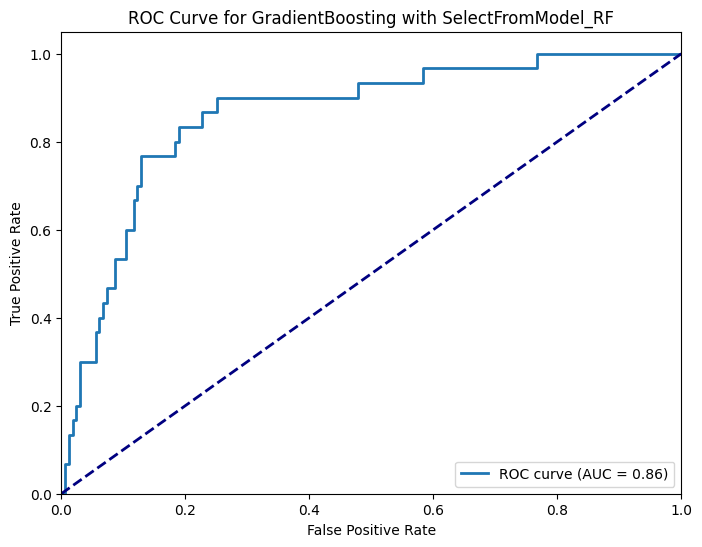

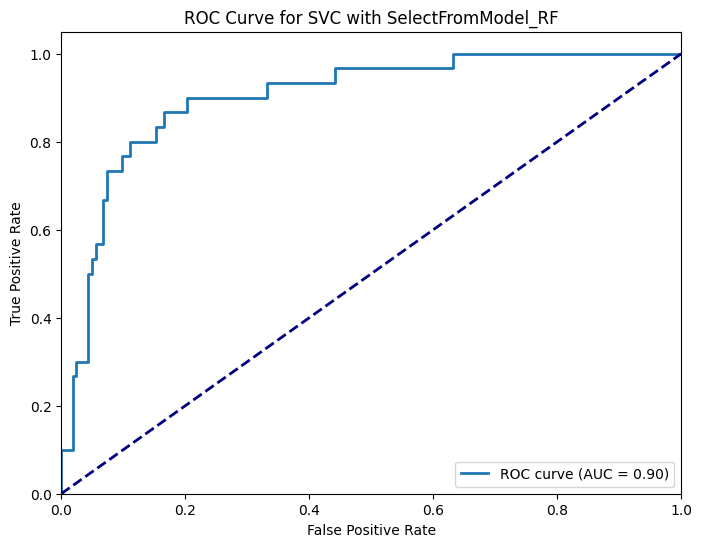

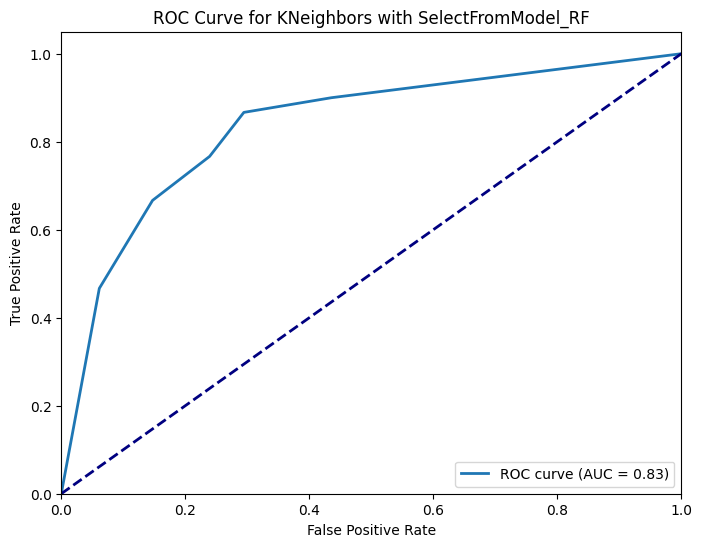

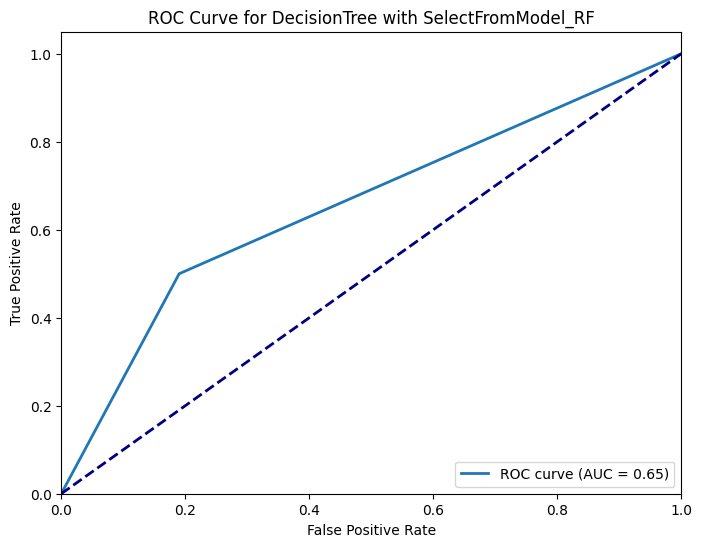

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import openpyxl

# Load the dataset
file_path = r'c:\Users\alire\Downloads\step 3 excel.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Ensure target variable is encoded properly
if df['label'].dtype == 'object':
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

# Remove non-numeric columns and separate features and target
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=['label'], errors='ignore')
y = df['label']

# Handle missing values (if any)
X = X.fillna(X.mean())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# List of feature selection methods
feature_selectors = {
    'SelectKBest_ANOVA': SelectKBest(score_func=f_classif, k=20),
    'VarianceThreshold': VarianceThreshold(threshold=0.0),  # Adjusted threshold to 0.0
    'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
}

# List of machine learning models (all models support predict_proba)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to store results and ROC curve data
results = []
roc_data = {}  # keys will be (model_name, fs_name) with values (fpr, tpr, auc)

# Iterate over feature selectors and models
for fs_name, fs in feature_selectors.items():
    # Fit the feature selector on training data
    fs.fit(X_train_resampled, y_train_resampled)
    X_train_fs = fs.transform(X_train_resampled)
    X_test_fs = fs.transform(X_test)
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fs, y_train_resampled)
        # Predict on test data
        y_pred = model.predict(X_test_fs)
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        
        # Get predicted probabilities for the positive class and compute ROC AUC
        y_prob = model.predict_proba(X_test_fs)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        
        # Compute ROC curve data
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # Save the metrics and ROC data, now including Accuracy
        results.append({
            'Feature_Selection': fs_name,
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'Accuracy': accuracy,
            'ROC_AUC': auc
        })
        roc_data[(model_name, fs_name)] = (fpr, tpr, auc)
        
        print(f"Completed {model_name} with {fs_name}")

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame(results)
output_file = r'e:\model_comparison_results_radiomics.xlsx'  # Change the output file path if needed
results_df.to_excel(output_file, index=False)
print(f"\nAll results have been saved to {output_file}")

# Generate separate ROC plots for each (model, feature selection) combination
for (model_name, fs_name), (fpr, tpr, auc) in roc_data.items():
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} with {fs_name}')
    plt.legend(loc="lower right")
    plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import openpyxl

# Load the dataset
file_path = r'c:\Users\alire\Downloads\labelstep3 (1).xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Ensure target variable is encoded properly
if df['Cancer Status'].dtype == 'object':
    le = LabelEncoder()
    df['Cancer Status'] = le.fit_transform(df['Cancer Status'])

# Remove non-numeric columns and separate features and target
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=['Cancer Status'], errors='ignore')
y = df['Cancer Status']

# Handle missing values (if any)
X = X.fillna(X.mean())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# List of feature selection methods
feature_selectors = {
    'SelectKBest_ANOVA': SelectKBest(score_func=f_classif, k=20),
    'VarianceThreshold': VarianceThreshold(threshold=0.0),  # Adjusted threshold to 0.0
    'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
}

# List of machine learning models (all models support predict_proba)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to store results and ROC curve data
results = []
roc_data = {}  # keys will be (model_name, fs_name) with values (fpr, tpr, auc)

# Iterate over feature selectors and models
for fs_name, fs in feature_selectors.items():
    # Fit the feature selector on training data
    fs.fit(X_train_resampled, y_train_resampled)
    X_train_fs = fs.transform(X_train_resampled)
    X_test_fs = fs.transform(X_test)
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fs, y_train_resampled)
        # Predict on test data
        y_pred = model.predict(X_test_fs)
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        # Get predicted probabilities for the positive class and compute ROC AUC
        y_prob = model.predict_proba(X_test_fs)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        
        # Compute ROC curve data
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # Save the metrics and ROC data
        results.append({
            'Feature_Selection': fs_name,
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'Accuracy': accuracy,
            'ROC_AUC': auc
        })
        roc_data[(model_name, fs_name)] = (fpr, tpr, auc)
        
        print(f"Completed {model_name} with {fs_name}")

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame(results)
output_file = r'e:\model_comparison_results_deep.xlsx'  # Change the output file path if needed
results_df.to_excel(output_file, index=False)
print(f"\nAll results have been saved to {output_file}")

# Generate separate ROC plots for each (model, feature selection) combination
for (model_name, fs_name), (fpr, tpr, auc) in roc_data.items():
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} with {fs_name}')
    plt.legend(loc="lower right")
    plt.show()

c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   9   21   62   76   99  114  134  173  194  199  226  233  240  265
  277  309  318  326  332  355  370  390  429  450  455  482  489  496
  521  533  574  582  588  611  626  646  655  685  706  711  738  745
  752  777  789  844  867  882  902  941  951  962 1001 1008 1033 1045
 1086 1094 1100 1123 1138 1158 1197 1207 1218 1223 1250 1257 1264] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


NameError: name 'accuracy' is not defined

c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   9   21   62   76   99  114  134  173  194  199  226  233  240  265
  277  309  318  326  332  355  370  390  429  450  455  482  489  496
  521  533  574  582  588  611  626  646  655  685  706  711  738  745
  752  777  789  844  867  882  902  941  951  962 1001 1008 1033 1045
 1086 1094 1100 1123 1138 1158 1197 1207 1218 1223 1250 1257 1264] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Completed LogisticRegression with SelectKBest_ANOVA
Completed RandomForest with SelectKBest_ANOVA
Completed GradientBoosting with SelectKBest_ANOVA
Completed SVC with SelectKBest_ANOVA
Completed KNeighbors with SelectKBest_ANOVA
Completed DecisionTree with SelectKBest_ANOVA
Completed LogisticRegression with VarianceThreshold
Completed RandomForest with VarianceThreshold
Completed GradientBoosting with VarianceThreshold
Completed SVC with VarianceThreshold
Completed KNeighbors with VarianceThreshold
Completed DecisionTree with VarianceThreshold
Completed LogisticRegression with SelectFromModel_RF
Completed RandomForest with SelectFromModel_RF
Completed GradientBoosting with SelectFromModel_RF
Completed SVC with SelectFromModel_RF
Completed KNeighbors with SelectFromModel_RF
Completed DecisionTree with SelectFromModel_RF

All results have been saved to e:\model_comparison_results_deep.xlsx


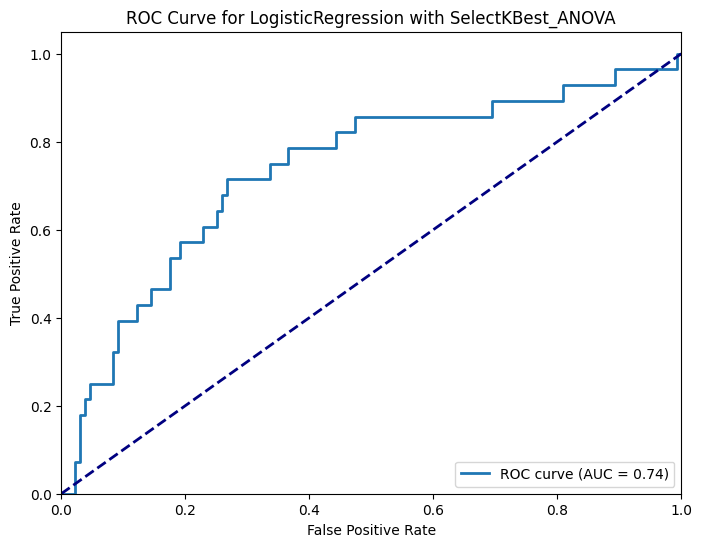

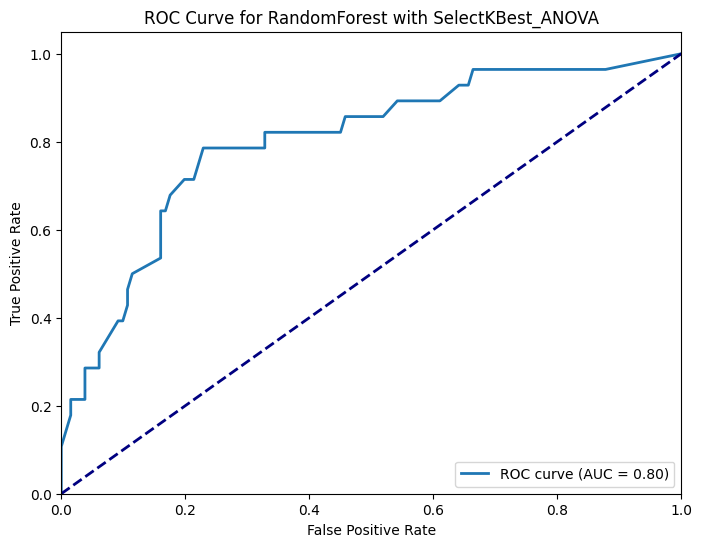

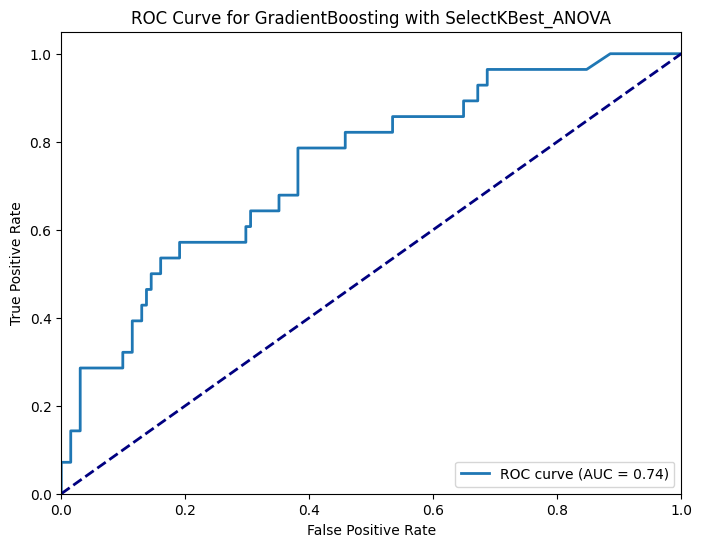

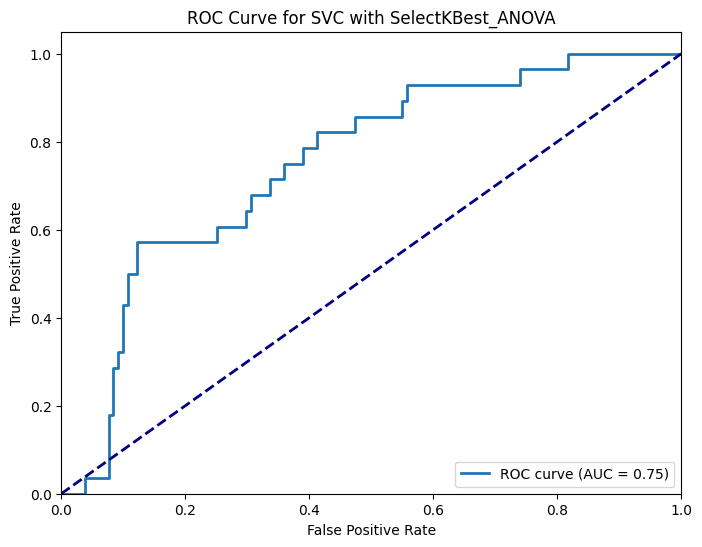

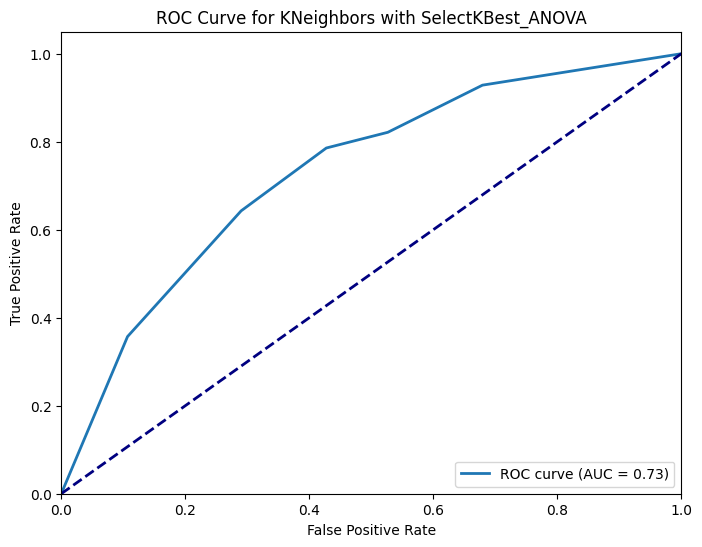

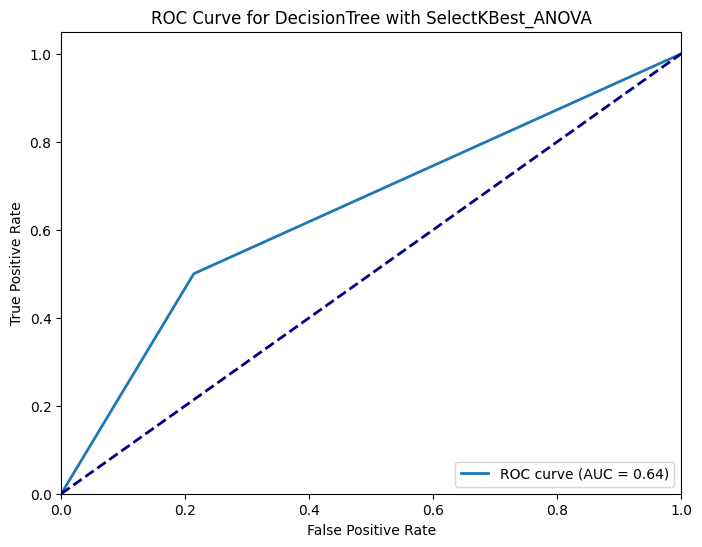

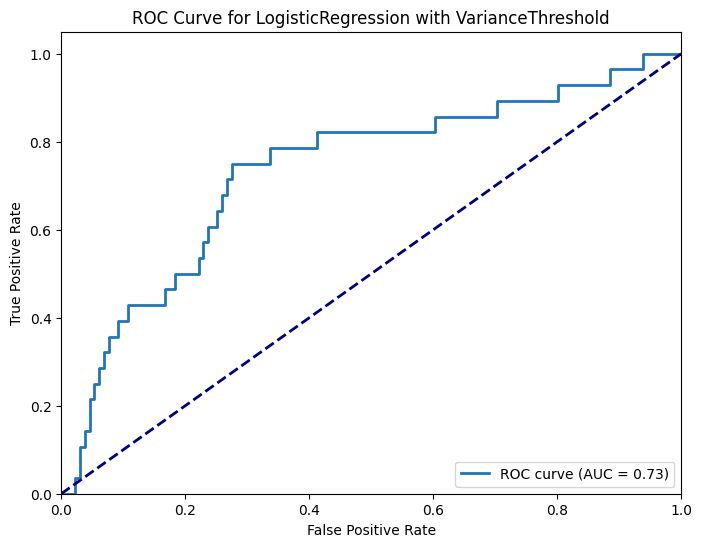

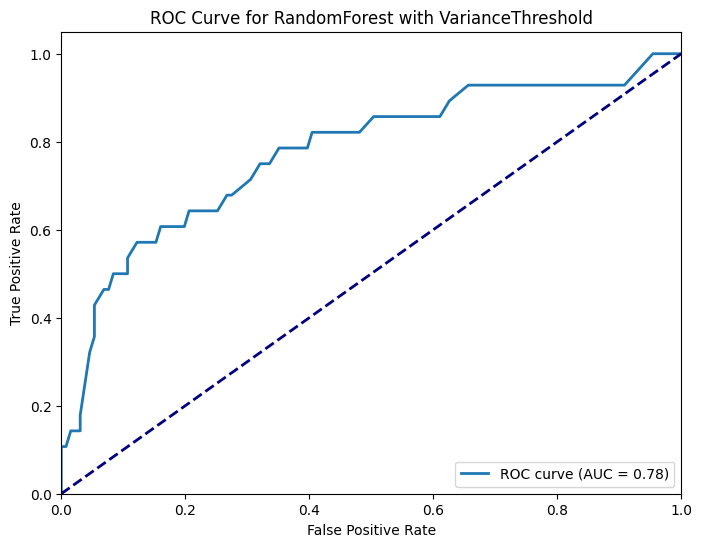

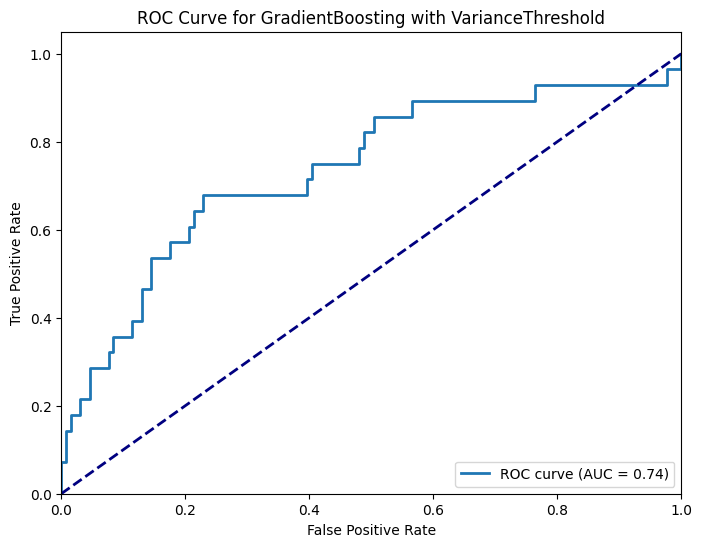

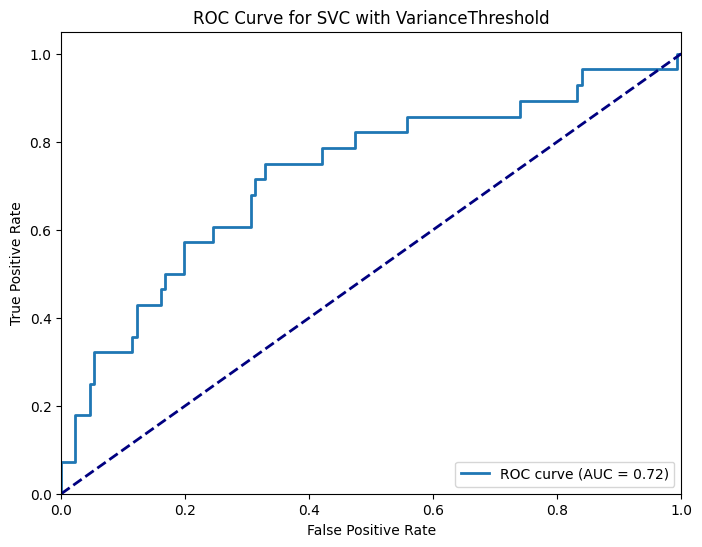

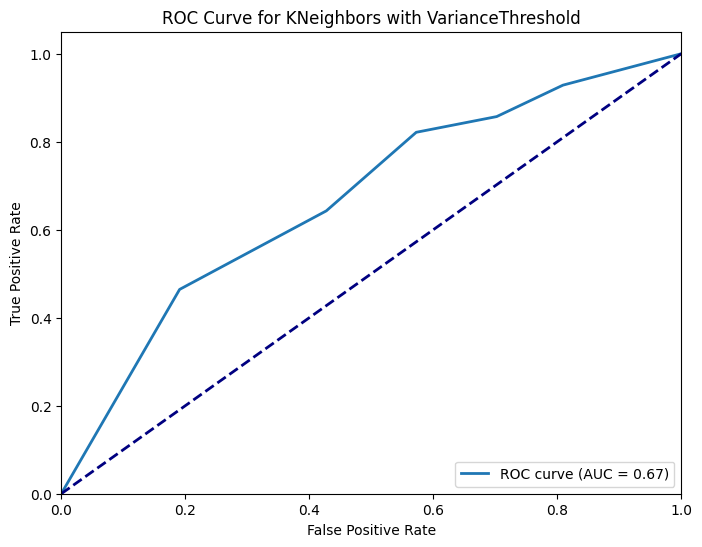

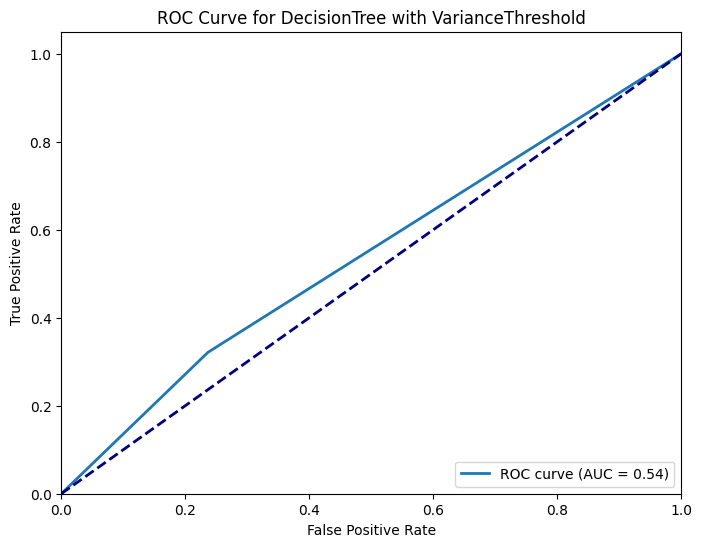

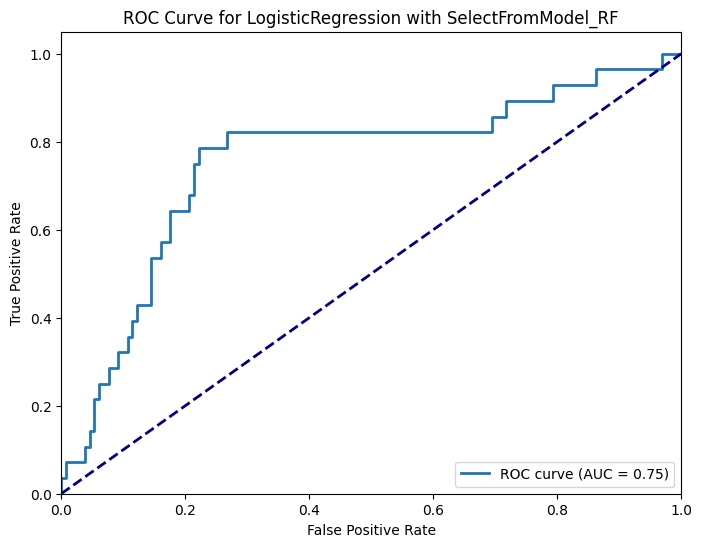

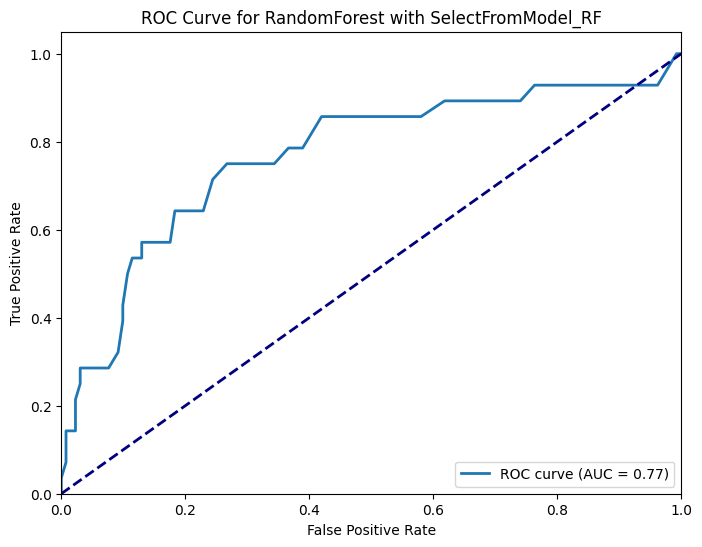

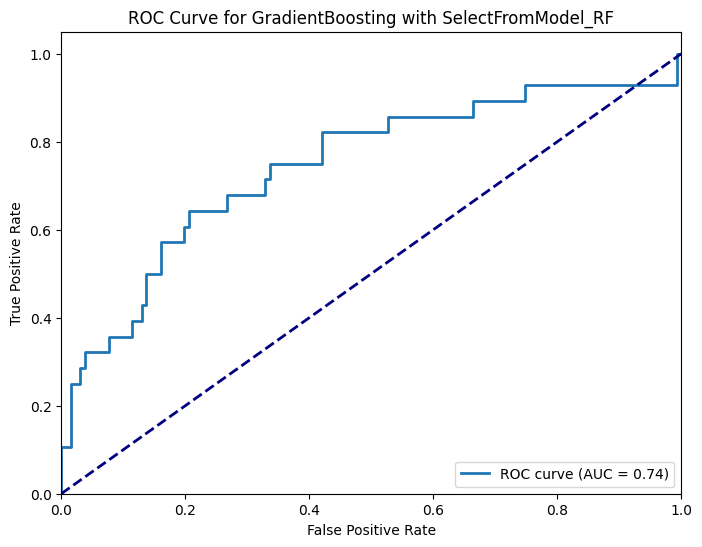

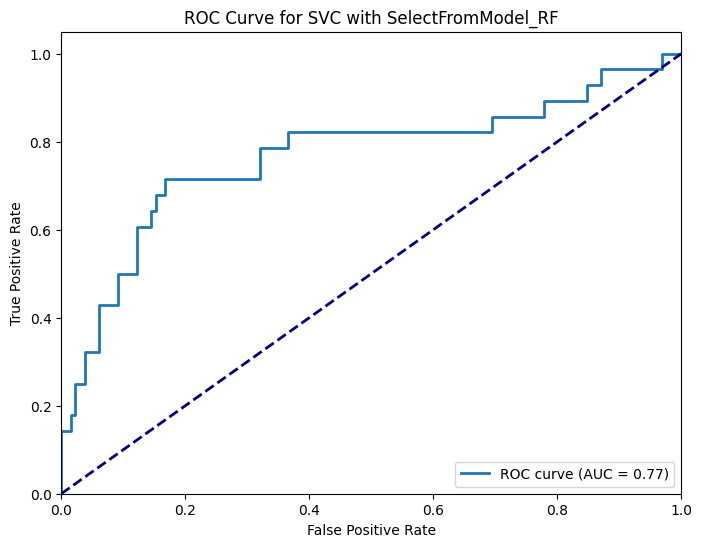

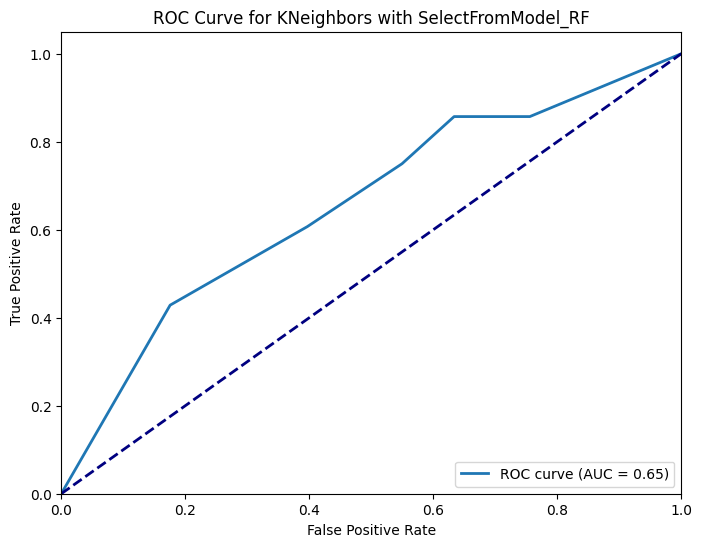

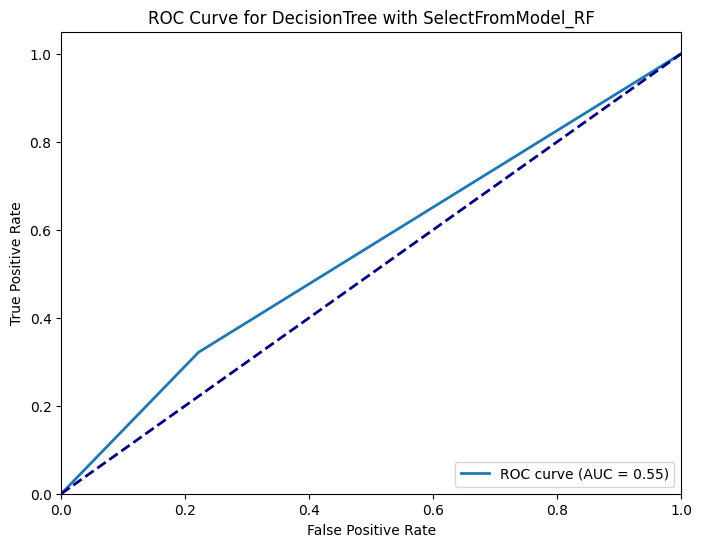

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
import openpyxl

# Load the dataset
file_path = r'c:\Users\alire\Downloads\labelstep3 (1).xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Ensure target variable is encoded properly
if df['Cancer Status'].dtype == 'object':
    le = LabelEncoder()
    df['Cancer Status'] = le.fit_transform(df['Cancer Status'])

# Remove non-numeric columns and separate features and target
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=['Cancer Status'], errors='ignore')
y = df['Cancer Status']

# Handle missing values (if any)
X = X.fillna(X.mean())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# List of feature selection methods
feature_selectors = {
    'SelectKBest_ANOVA': SelectKBest(score_func=f_classif, k=20),
    'VarianceThreshold': VarianceThreshold(threshold=0.0),  # Adjusted threshold to 0.0
    'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
}

# List of machine learning models (all models support predict_proba)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to store results and ROC curve data
results = []
roc_data = {}  # keys will be (model_name, fs_name) with values (fpr, tpr, auc)

# Iterate over feature selectors and models
for fs_name, fs in feature_selectors.items():
    # Fit the feature selector on training data
    fs.fit(X_train_resampled, y_train_resampled)
    X_train_fs = fs.transform(X_train_resampled)
    X_test_fs = fs.transform(X_test)
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fs, y_train_resampled)
        # Predict on test data
        y_pred = model.predict(X_test_fs)
        
        # Calculate metrics
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        # Get predicted probabilities and compute ROC AUC
        y_prob = model.predict_proba(X_test_fs)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        
        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Compute ROC curve data
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # Save the metrics and ROC data
        results.append({
            'Feature_Selection': fs_name,
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'Accuracy': accuracy,
            'ROC_AUC': auc
        })
        roc_data[(model_name, fs_name)] = (fpr, tpr, auc)
        
        print(f"Completed {model_name} with {fs_name}")

# Convert results to DataFrame and save to Excel
results_df = pd.DataFrame(results)
output_file = r'e:\model_comparison_results_deep.xlsx'  # Change the output file path if needed
results_df.to_excel(output_file, index=False)
print(f"\nAll results have been saved to {output_file}")

# Generate separate ROC plots for each (model, feature selection) combination
for (model_name, fs_name), (fpr, tpr, auc) in roc_data.items():
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} with {fs_name}')
    plt.legend(loc="lower right")
    plt.show()
